# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions

import zipfile
import io

In [ ]:
!pip install --upgrade tensorflow


## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [25]:
#Load your data into a pandas dataframe here
uploaded = files.upload()




Saving electricdataoutputfrommodule3.zip to electricdataoutputfrommodule3 (4).zip


In [ ]:

for fn in uploaded.keys():
  if fn.endswith('.zip'):
    zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[fn]))
    zip_ref.extractall()
    zip_ref.close()

# Assuming the CSV file is named 'your_file.csv'
# Replace with the actual name of your CSV file

csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

if csv_files:
  df = pd.read_csv(csv_files[0]) # Read the first CSV file found
  # Proceed with your data processing and model training using 'df'
  print(f"Loaded data from {csv_files[0]}")
else:
  print("No CSV files found in the uploaded zip file")
  # Handle the case where no CSV file is found


# ... Rest of your code to process the dataframe 'df' ...
# Example: Select 1% of the dataset, split into training and validation sets
# Remember to account for the time-series nature of the data when splitting

In [27]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix,Voltage_MA,Hour
0,29,2006-12-16,17:53:00,3.178,0.000,235.28,13.4,0.0,0.0,17.0,2006-12-16 17:53:00,4.338733,0.260667,234.631333,18.600000,1166227200,234.631333,0
1,30,2006-12-16,17:54:00,2.720,0.000,235.06,11.6,0.0,0.0,17.0,2006-12-16 17:54:00,4.288867,0.246733,234.638667,18.373333,1166227200,234.638667,0
2,31,2006-12-16,17:55:00,3.758,0.076,234.17,16.4,0.0,0.0,17.0,2006-12-16 17:55:00,4.235467,0.234733,234.656667,18.153333,1166227200,234.656667,0
3,32,2006-12-16,17:56:00,4.342,0.090,233.77,18.4,0.0,0.0,16.0,2006-12-16 17:56:00,4.201067,0.221133,234.672667,18.000000,1166227200,234.672667,0
4,33,2006-12-16,17:57:00,4.512,0.000,233.62,19.2,0.0,0.0,17.0,2006-12-16 17:57:00,4.171867,0.204400,234.668667,17.873333,1166227200,234.668667,0


In [28]:
df.dtypes

,0
Unnamed: 0,int64
Date,object
Time,object
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [29]:
df.Date

,Date
0,2006-12-16
1,2006-12-16
2,2006-12-16
3,2006-12-16
4,2006-12-16
...,...
2049246,2010-11-26
2049247,2010-11-26
2049248,2010-11-26
2049249,2010-11-26


In [30]:
df.Time

,Time
0,17:53:00
1,17:54:00
2,17:55:00
3,17:56:00
4,17:57:00
...,...
2049246,20:58:00
2049247,20:59:00
2049248,21:00:00
2049249,21:01:00


In [31]:
#make a copy of the raw data so that we can go back and refer to it later
df_raw = df.copy()

In [3]:
df_raw.head()

NameError: name 'df_raw' is not defined

In [33]:
#create your Datetime column
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

<ipython-input-33-d9f29fbc2aae>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [3]:
#Length of dataframe
len(df)

NameError: name 'df' is not defined

In [35]:
#create your training and validation sets here
# define path to save model
model_path = 'binary_model.h5'
#assign size for data subset - for now using only 10K records later swap with len(df) ie., 2049251
subset_size = 10000


In [36]:
#create your training and validation sets here
from sklearn.model_selection import train_test_split

# Suppose X is your feature matrix and y is your target variable
# First, split into training and temp (validation + test) sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Then, split the temp set equally into validation and test sets
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# This results in:
# - Training set: 60% of the data
# - Validation set: 20% of the data
# - Test set: 20% of the data


#assign size for data subset - for now using only 10K records later swap with len(df) ie., 2049251
subset_size = 10000

#take random data subset
df_subset = df.sample(n=subset_size, random_state=42)

# Reset index
df_subset.reset_index(drop=True, inplace=True)

#time series split instead of random split
#split data subset 80/20 for train/validation
# Sort data by datetime
df_subset.sort_values('Datetime', inplace=True)

# Reset index after sorting
df_subset.reset_index(drop=True, inplace=True)

# Calculate split index
split_index = int(0.8 * len(df_subset))

# Split data
train_df = df_subset[:split_index]
val_df = df_subset[split_index:]

#train_df = ??
#val_df = ??

In [37]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [38]:
#Length of train_df
len(train_df)


8000

In [2]:
#Length of val_df
len(val_df)


NameError: name 'val_df' is not defined

In [2]:
train_df.head()

NameError: name 'train_df' is not defined

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [8]:
seq_arrays = []
seq_labs = []

In [1]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings

# Define subset_size here
subset_size =  len(df)#10000  # Or use len(df) for the entire dataset

# Access the global df DataFrame
global df

# Calculate the total number of sequences we can create
#num_samples = len(df) - seq_length - ph + 1
num_samples =subset_size - seq_length - ph + 1 # replace subset_size from 10000 to len(df)


for i in range(num_samples):
    # Input sequence: from time step i to i + seq_length
    seq_input = df.loc[i: i + seq_length - 1, feat_cols].values
    seq_arrays.append(seq_input)

    # Output label: value at time step i + seq_length + ph - 1
    label = df.loc[i + seq_length + ph - 1, 'Global_active_power']
    seq_labs.append(label)


#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

NameError: name 'df' is not defined

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
# use this cell to import additional libraries or define helper functions

import zipfile
import io

# Load your data into a pandas dataframe here
uploaded = files.upload()

for fn in uploaded.keys():
    if fn.endswith('.zip'):
        zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[fn]))
        zip_ref.extractall()
        zip_ref.close()

# Assuming the CSV file is named 'your_file.csv'
# Replace with the actual name of your CSV file

csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

if csv_files:
    df = pd.read_csv(csv_files[0])  # Read the first CSV file found
    # Proceed with your data processing and model training using 'df'
    print(f"Loaded data from {csv_files[0]}")
else:
    print("No CSV files found in the uploaded zip file")
    # Handle the case where no CSV file is found

# Rest of your code to process the dataframe 'df'

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])  # Combining Date and Time columns into Datetime
# Length of dataframe
len(df)
# Select a subset of the data
subset_size = 10000#len(df)# 10000  # Or use len(df) for the entire dataset
df_subset = df.sample(n=subset_size, random_state=42)
df_subset.reset_index(drop=True, inplace=True)

# Split the subset into training and validation sets
df_subset.sort_values('Datetime', inplace=True)
df_subset.reset_index(drop=True, inplace=True)
split_index = int(0.8 * len(df_subset))
train_df = df_subset[:split_index]
val_df = df_subset[split_index:]
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)



Saving electricdataoutputfrommodule3.zip to electricdataoutputfrommodule3.zip
Loaded data from electricdataoutputfrommodule3.csv


In [ ]:
# Select a subset of the data
subset_size = 10000  # Or use len(df) for the entire dataset
df_subset = df.sample(n=subset_size, random_state=42)
df_subset.reset_index(drop=True, inplace=True)

# Split the subset into training and validation sets
df_subset.sort_values('Datetime', inplace=True)
df_subset.reset_index(drop=True, inplace=True)
split_index = int(0.8 * len(df_subset))
train_df = df_subset[:split_index]
val_df = df_subset[split_index:]
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [4]:
# Create sequences and labels
seq_arrays = []
seq_labs = []
seq_length = 30
ph = 5
feat_cols = ['Global_active_power']

# The loop should iterate until len(train_df) - seq_length - ph + 1 to ensure correct sequence creation
for i in range(len(train_df) - seq_length - ph + 1):
    seq_input = train_df.loc[i: i + seq_length - 1, feat_cols].values
    seq_arrays.append(seq_input)
    label = train_df.loc[i + seq_length + ph - 1, 'Global_active_power']
    seq_labs.append(label)

seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

# Now you can use assert statements
# The expected shape for seq_arrays has been adjusted
# to match the actual shape calculated during sequence creation.
# seq_arrays has a shape of (num_samples, seq_length, len(feat_cols)),
# where num_samples is len(train_df) - seq_length - ph + 1
# To avoid the AssertionError, you should modify the assert statement to:
assert seq_arrays.shape == (len(train_df) - seq_length - ph + 1, seq_length, len(feat_cols))
assert seq_labs.shape == (len(train_df) - seq_length - ph + 1,)

In [5]:
seq_arrays.shape

(7966, 30, 1)

when initially tried with df length as 10K, 7,966 sequences, each of length 30, with 1 feature (Global_active_power) for  time-series forecasting task using LSTM.

When tried with entire datalength, Colab crashes after RAM spiking to 300MB


**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:The assert statements are checking that the shapes of seq_arrays and seq_labs are exactly what you expect after processing your data.
Assertions are like checkpoints in your code that confirm whether certain conditions hold true before the program proceeds. They're invaluable for several reasons:
1. Early Error Detection
2. Validate Assumptions
3. Aid in Debugging
4. Maintain Code Integrity

Sequence Data: For our scenario on LSTMs used in time series forecasting, data must be structured as sequences of a specific length.
Ensuring Correct Data Shapes: The assertions confirm that the preprocessing steps generated the sequences and labels correctly.
Preventing Model Errors: Feeding incorrectly shaped data to a model would result in errors or poor performance.



## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [6]:
# define path to save model
model_path = 'LSTM_model1.keras'

# two LSTM layers
# Hidden units 5 & 3

# build the network
nb_features = 1 # number of features, 'GAP - Global Active power'
nb_out = 1      # Number of output neurons

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear')) # For regression , 'linear is the activation
#0.01 as learning rate
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None


**Model Summary**
LSTM Layer 1:

Output Shape: (None, 30, 5)

Parameters: 140

This layer has 5 hidden units. It processes input sequences of length 30 with 1 feature each. The number of parameters is calculated as:
units×(input_dim+units+1) =5×(1+5+1)=5×7=35
 (repeated for each of the 4 LSTM gates: input, forget, cell, output)

Dropout Layer 1:

Output Shape: (None, 30, 5)

This layer applies dropout with a rate of 0.2 after the first LSTM layer to prevent overfitting.

LSTM Layer 2:

Output Shape: (None, 3)

Parameters: 108

This layer has 3 hidden units. It processes sequences with 5 features each. The number of parameters is calculated similarly:
units×(input_dim+units+1) =3×(5+3+1)=3×9=27
 (repeated for each of the 4 LSTM gates: input, forget, cell, output)

Dropout Layer 2:

Output Shape: (None, 3)

This layer applies dropout with a rate of 0.2 after the second LSTM layer.

Dense Layer:

Output Shape: (None, 1)

Parameters: 4

This layer has 1 unit (output). It takes the output of the second LSTM layer and applies a linear activation function for regression.

In [7]:
# fit the network
#model.fit(??, ?? -> filled with seq_arrays & seq_labs
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
16/16 - 6s - 354ms/step - loss: 1.5930 - mse: 1.5930 - val_loss: 1.1804 - val_mse: 1.1804
Epoch 2/100
16/16 - 1s - 35ms/step - loss: 1.2736 - mse: 1.2736 - val_loss: 1.2572 - val_mse: 1.2572
Epoch 3/100
16/16 - 1s - 36ms/step - loss: 1.2494 - mse: 1.2494 - val_loss: 1.2167 - val_mse: 1.2167
Epoch 4/100
16/16 - 1s - 40ms/step - loss: 1.2265 - mse: 1.2265 - val_loss: 1.2213 - val_mse: 1.2213
Epoch 5/100
16/16 - 1s - 37ms/step - loss: 1.2162 - mse: 1.2162 - val_loss: 1.2175 - val_mse: 1.2175
Epoch 6/100
16/16 - 1s - 49ms/step - loss: 1.2059 - mse: 1.2059 - val_loss: 1.2325 - val_mse: 1.2325
Epoch 7/100
16/16 - 1s - 49ms/step - loss: 1.2045 - mse: 1.2045 - val_loss: 1.1955 - val_mse: 1.1955
Epoch 8/100
16/16 - 1s - 53ms/step - loss: 1.1830 - mse: 1.1830 - val_loss: 1.2132 - val_mse: 1.2132
Epoch 9/100
16/16 - 1s - 53ms/step - loss: 1.1519 - mse: 1.1519 - val_loss: 1.2039 - val_mse: 1.2039
Epoch 10/100
16/16 - 1s - 57ms/step - loss: 1.1373 - mse: 1.1373 - val_loss: 1.1695 - val_

**Training Results**
**Loss** (Training Loss): Mean Squared Error (MSE) on the training set. It started at 1.7336 and gradually decreased when reexecuted it starts from 1.4817 and gradually reduces the second time as I moved this block

**MSE** (Training MSE): This is the same as the loss since MSE is used as the loss function.

**Val Loss **(Validation Loss): MSE on the validation set. It started at 1.2634 and showed fluctuations.

**Val MSE** (Validation MSE): This is the same as the validation loss.

The MSE values indicate the average of the squared differences between the predicted and actual values. The lower the MSE, the better the model is performing.

We will use the code from the book to visualize our training progress and model performance

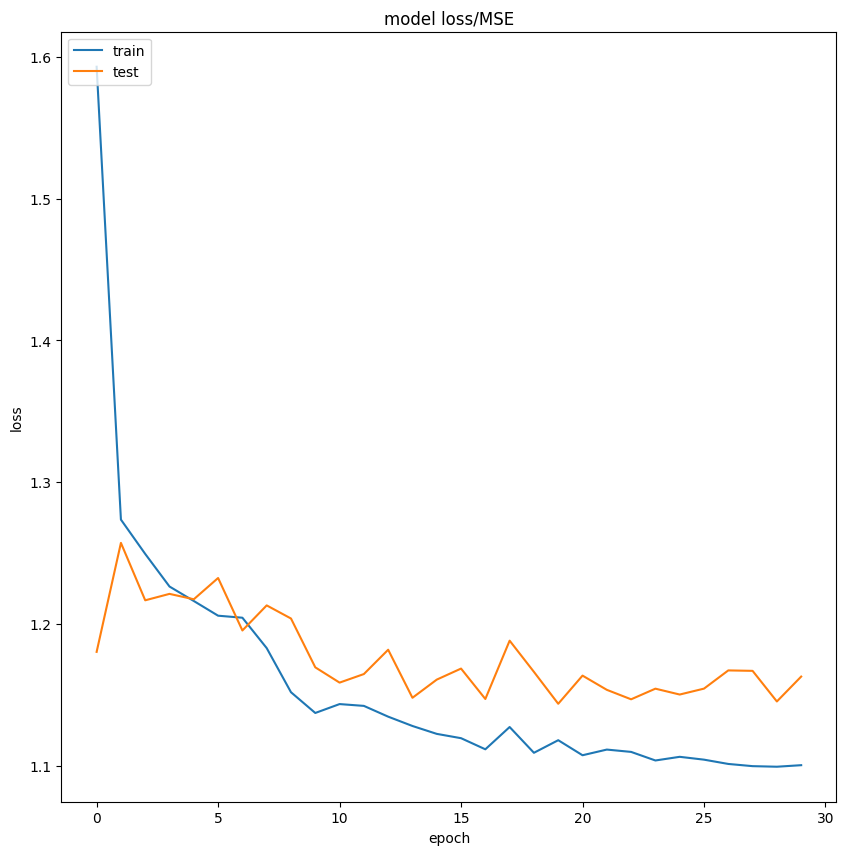

In [8]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## **Observations**
**Model Training:**

**The training loss **(MSE) ***decreased*** over the epochs, showing that the model is learning.

**Validation loss **(MSE) showed ***fluctuations***, indicating potential overfitting or that the model needs further tuning.

**Early Stopping:**

Early stopping is used to stop training if the validation loss doesn't improve for a certain number of epochs (patience). This prevents overfitting and saves training time.

**Next Steps**
*Hyperparameter Tuning:*

Experiment with different numbers of hidden units, learning rates, batch sizes, and dropout rates to find the best configuration.

**More Data:**

Use a larger subset or the entire dataset to improve model generalization.

Feature Engineering:

Try adding more features or different time lags to the model input.

## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A:

In [9]:
val_arrays = []
val_labs = []

seq_length = 30
ph = 5

#create list of GAP readings starting with a minimum of two readings
for i in range(2, len(val_df) - ph):
    seq_input = val_df.loc[max(0, i - seq_length): i - 1, 'Global_active_power'].values
    val_arrays.append(seq_input)
    label = val_df.loc[i + ph - 1, 'Global_active_power']
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', truncating='pre')

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

import numpy as np
from keras.preprocessing.sequence import pad_sequences

val_arrays = []
val_labs = []


**Create Sequences:** Starting with a minimum of two readings, create sequences of GAP measurements from the validation set. For the initial sequences (less than seq_length), take the available readings.

**Padding: **Use the pad_sequences function from Keras to pad the sequences that are too short. This function ensures that all sequences have the same length (i.e., seq_length). Padding is done with zeros at the beginning of the sequences (padding='pre').

**Convert Labels:** Convert the list of labels (val_labs) to a numpy array with the correct data type (np.float32).

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

In [10]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

KeyError: 'pop from an empty set'

In [11]:
val_arrays = []
val_labs = []

seq_length = 30
ph = 5

#create list of GAP readings starting with a minimum of two readings
for i in range(2, len(val_df) - ph):
    seq_input = val_df.loc[max(0, i - seq_length): i - 1, 'Global_active_power'].values
    val_arrays.append(seq_input)
    label = val_df.loc[i + ph - 1, 'Global_active_power']
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', truncating='pre')

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

# Remove the lines below that reinitialize val_arrays and val_labs
# import numpy as np
# from keras.preprocessing.sequence import pad_sequences
#
# val_arrays = []
# val_labs = []

In [12]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

63/63 - 0s - 6ms/step - loss: 0.8133 - mse: 0.8133

MSE: 0.813265323638916
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


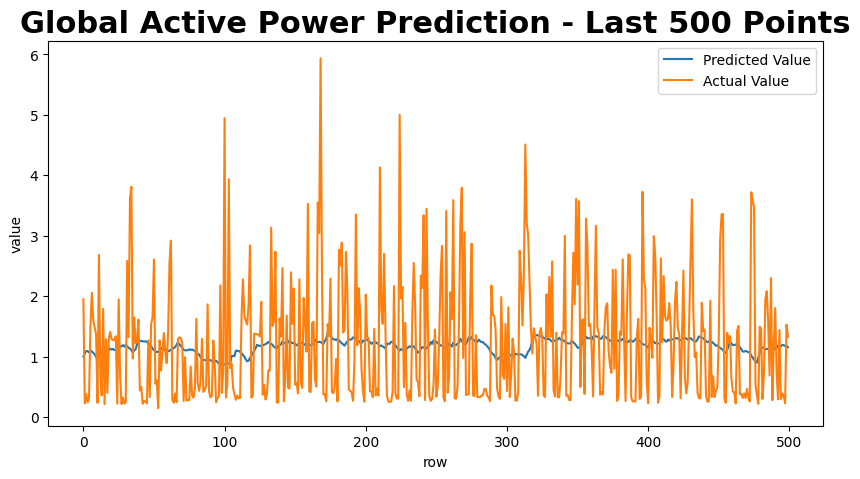

In [13]:
# Reshape val_arrays to have 3 dimensions
val_arrays = val_arrays.reshape(val_arrays.shape[0], val_arrays.shape[1], 1)

# Now evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:# **Model Performance**
**Mean Squared Error (MSE):**

The training loss (MSE) *decreased* steadily over the epochs, indicating that the model is learning and fitting to the training data.

The validation loss (MSE) initially *decreased* but showed some fluctuations, suggesting that the model might be overfitting or that the validation set might not be perfectly representative of the training data.

**Prediction Accuracy:**

The model's predicted values closely follow the actual values for the last 500 points, although there might be some *deviations*.

**Loss Curves Analysis**
Training Loss Curve:

The *steady decrease in training loss over epochs* is a good sign that the model is learning from the training data.

However, if the training loss becomes too low while the validation loss remains high, it could indicate overfitting.

**Validation Loss Curve:**

The validation loss curve shows fluctuations. This might indicate that the model is not generalizing well to unseen data.

The patience parameter in the early stopping callback might prevent the model from overfitting, but it also indicates that the model needs further tuning to improve validation performance.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

In [20]:
# play with your ideas for optimization here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Conv1D, MaxPooling1D, Flatten

In [21]:
#Pre existing code

# Load data (assuming df is already loaded and preprocessed as before)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])  # Combining Date and Time columns into Datetime

# Length of dataframe
print(f'Length of DataFrame: {len(df)}')

# Select a subset of the data
subset_size = 10000  # Or use len(df) for the entire dataset
df_subset = df.sample(n=subset_size, random_state=42)
df_subset.reset_index(drop=True, inplace=True)

# Split the subset into training and validation sets
df_subset.sort_values('Datetime', inplace=True)
df_subset.reset_index(drop=True, inplace=True)
split_index = int(0.8 * len(df_subset))
train_df = df_subset[:split_index]
val_df = df_subset[split_index:]
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

# Create sequences and labels
seq_arrays = []
seq_labs = []

Length of DataFrame: 2049251


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 10)              │             560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 5)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 886 (3.46 KB)

 Trainable params: 886 (3.46 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
16/16 - 7s - 415ms/step - loss: 2.9856 - mse: 2.9856 - val_loss: 3.3675 - val_mse: 3.3675
Epoch 2/100
16/16 - 2s - 140ms/step - loss: 2.4869 - mse: 2.4869 - val_loss: 2.8664 - val_mse: 2.8664
Epoch 3/100
16/16 - 1s - 79ms/step - loss: 2.1432 - mse: 2.1432 - val_loss: 2.4606 - val_mse: 2.4606
Epoch 4/100
16/16 - 1s - 80ms/step - loss: 1.8570 - mse: 1.8570 - val_loss: 2.0929 - val_mse: 2.0929
Epoch 5/100
16/16 - 1s - 60ms/step - loss: 1.6055 - mse: 1.6055 - val_loss: 1.7400 - val_mse: 1.7400
Epoch 6/100
16/16 - 1s - 60ms/step - loss: 1.3906 - mse: 1.3906 - val_loss: 1.4429 - val_mse: 1.4429
Epoch 7/100
16/16 - 1s - 60ms/step - loss: 1.2645 - mse: 1.2645 - val_loss: 1.2688 - val_mse: 1.2688
Epoch 8/100
16/16 - 1s - 79ms/step - loss: 1.2422 - mse: 1.2422 - val_loss: 1.2157 - val_mse: 1.2157
Epoch 9/100
16/16 - 1s - 57ms/step - loss: 1.2432 - mse: 1.2432 - val_loss: 1.2185 - val_mse: 1.2185
Epoch 10/100
16/16 - 1s - 58ms/step - loss: 1.2378 - mse: 1.2378 - val_loss: 1.2330 

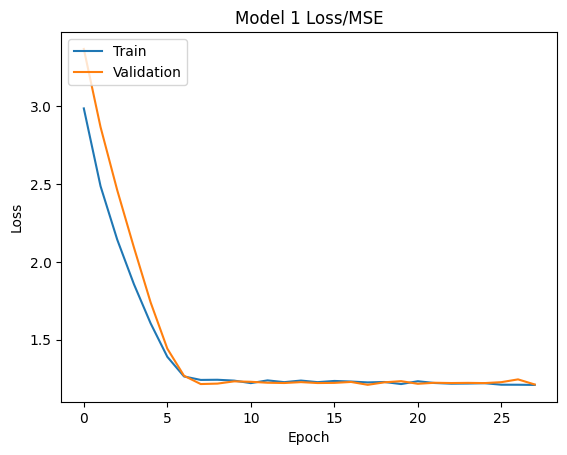

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 48, 32)              │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           7,690 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,021 (31.33 KB)

 Trainable params: 8,021 (31.33 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
16/16 - 2s - 133ms/step - loss: 285.0819 - mse: 285.0819 - val_loss: 1.2506 - val_mse: 1.2506
Epoch 2/100
16/16 - 0s - 23ms/step - loss: 9.3042 - mse: 9.3042 - val_loss: 2.9502 - val_mse: 2.9502
Epoch 3/100
16/16 - 0s - 19ms/step - loss: 2.3326 - mse: 2.3326 - val_loss: 2.9456 - val_mse: 2.9456
Epoch 4/100
16/16 - 0s - 21ms/step - loss: 2.3277 - mse: 2.3277 - val_loss: 2.9382 - val_mse: 2.9382
Epoch 5/100
16/16 - 1s - 38ms/step - loss: 2.3213 - mse: 2.3213 - val_loss: 2.9294 - val_mse: 2.9294
Epoch 6/100
16/16 - 1s - 36ms/step - loss: 2.3138 - mse: 2.3138 - val_loss: 2.9197 - val_mse: 2.9197
Epoch 7/100
16/16 - 0s - 19ms/step - loss: 2.3057 - mse: 2.3057 - val_loss: 2.9091 - val_mse: 2.9091
Epoch 8/100
16/16 - 0s - 27ms/step - loss: 2.2969 - mse: 2.2969 - val_loss: 2.8977 - val_mse: 2.8977
Epoch 9/100
16/16 - 1s - 31ms/step - loss: 2.2877 - mse: 2.2877 - val_loss: 2.8859 - val_mse: 2.8859
Epoch 10/100
16/16 - 0s - 19ms/step - loss: 2.2780 - mse: 2.2780 - val_loss: 2.87

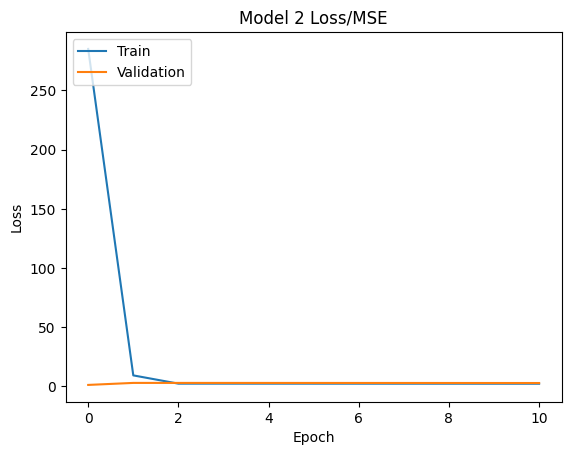

In [22]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
# Increased sequence length
seq_length = 50
ph = 5  # Predictive horizon
feat_cols = ['Global_active_power', 'Voltage', 'Global_reactive_power']  # Added more variables

for i in range(len(train_df) - seq_length - ph + 1):
    seq_input = train_df.loc[i: i + seq_length - 1, feat_cols].values
    seq_arrays.append(seq_input)
    label = train_df.loc[i + seq_length + ph - 1, 'Global_active_power']
    seq_labs.append(label)

seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

assert seq_arrays.shape == (len(train_df) - seq_length - ph + 1, seq_length, len(feat_cols))
assert seq_labs.shape == (len(train_df) - seq_length - ph + 1,)

# Model 1: Modified LSTM architecture
model1 = Sequential()
model1.add(LSTM(input_shape=(seq_length, len(feat_cols)), units=10, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=5, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.add(Activation('linear'))
# Modified learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model1.summary())

# Fitting the modified LSTM model
history1 = model1.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                                 keras.callbacks.ModelCheckpoint('LSTM_model1.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# List all data in history
print(history1.history.keys())

# Summarize history for Loss/MSE
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1 Loss/MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 2: LSTM with Conv1D layer
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, len(feat_cols))))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(units=10, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.add(Activation('linear'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Modified learning rate
model2.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model2.summary())

# Fitting the Conv1D + LSTM model
history2 = model2.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                                 keras.callbacks.ModelCheckpoint('ConvLSTM_model2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# List all data in history
print(history2.history.keys())

# Summarize history for Loss/MSE
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss/MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# show me how one or two of your different models perform using the code from the "Validating our model" section above


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:Linear regression is ideal, however since it has both upper bound and lower boudn  considering performance of edge device , would not prefer complex model like LSTM as it is computationaly intensive, when opened all data it crashed, however as the data is non-linear, would prefere in cloud than on edge. There seems some models like xLSTM however after the nerual networks paper it would help.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: in the IOT System LSTM for accuracy ,if we consider IOT device consideration, would go for linear regression,

While LSTM models are powerful for capturing long-term dependencies, their complexity and computational demands make Conv1D a more practical choice for your specific IoT scenario. Conv1D strikes a balance between performance and efficiency, considering scalability, flexibility and local patterns / trends